# PINNs for continnuum mechanics 

In this work we adress the boundary value problem introduced in [1] that has an analytical solution (considering linear elasticity).

We consider the unit square domain : $\Omega = [0,1]^2$, on which the continnum mechanics equations applies :

$ \epsilon_{ij} = \frac{1}{2}(u_{i,j}+u_{j,i}) $\
$ \sigma_{ij} =  \lambda \epsilon_{ij} \delta{ij} + 2 \mu \epsilon_{ij}$\
$ \sigma_{ij,j} + f_{i} = 0 $

The boundary condition are summarized in the image bellow [1], and the body forces are choosen on purpose so that there can be an analytical solution :

$fx = \lambda \left(- \pi Q y^{3} \cos{\left(\pi x \right)} + 4 \pi^{2} \sin{\left(2 \pi y \right)} \cos{\left(2 \pi x \right)}\right) + \mu \left(- \pi Q y^{3} \cos{\left(\pi x \right)} + 9 \pi^{2} \sin{\left(\pi y \right)}\right)$\
$fy = \lambda \left(- 3 Q y^{2} \sin{\left(\pi x \right)} + 2 \pi^{2} \sin{\left(2 \pi x \right)} \cos{\left(\pi y \right)}\right) + \mu \left(\frac{\pi^{2} Q y^{4} \sin{\left(\pi x \right)}}{16} - 6 Q y^{2} \sin{\left(\pi x \right)} + 2 \pi^{2} \sin{\left(2 \pi x \right)} \cos{\left(\pi y \right)}\right)$


[1] Haghighat, Ehsan, Maziar Raissi, Adrian Moure, Hector Gomez, and Ruben Juanes. “A Deep Learning Framework for Solution and Discovery in Solid Mechanics.” 

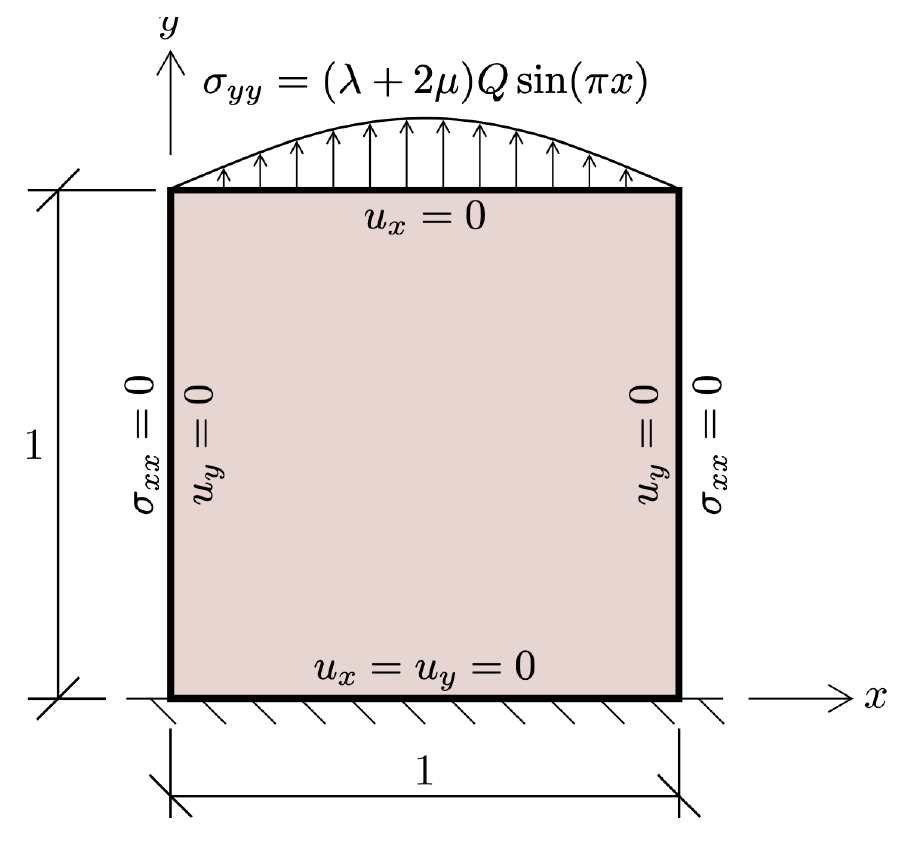

In [2]:
from IPython.display import Image
Image(filename=r'figure/SciANN_example.png', width=500)

In [3]:
# useful libraries
from sympy import *
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid") # better looking plots

## Analytical solution resolution using symbolic math (sympy)

In [4]:
## Analytical solution

# define symbols
x, y, Q_, lambda_, mu_ = symbols('x y Q lambda mu')

# define body force
fx = lambda_*(4*pi**2*cos(2*pi*x)*sin(pi*y)-pi*cos(pi*x)*Q_*y**3) \
    + mu_*(9*pi**2*cos(2*pi*x)*sin(pi*y) - pi*cos(pi*x)*Q_*y**3)

fy = lambda_*(-3*sin(pi*x)*Q_*y**2 + 2*pi**2*sin(2*pi*x)*cos(pi*y)) \
    + mu_*(-6*sin(pi*x)*Q_*y**2 + 2*pi**2*sin(2*pi*x)*cos(pi*y) + (pi**2*sin(pi*x)*Q_*y**4)/4)

# define displacement (known analytical solution)
Ux = cos(2*pi*x)*sin(pi*y)
Uy = sin(pi*x)*Q_*y**4/4 
#--> the boundary are directly satisfied

# compute strain and stress
Exx = diff(Ux,x)
Eyy = diff(Uy,y)
Exy = 1/2*(diff(Uy,x) + diff(Ux,y))

Sxx = (lambda_ + 2*mu_) * Exx + lambda_ * Eyy
Syy = (lambda_ + 2*mu_) * Eyy + lambda_ * Exx
Sxy = 2*mu_*Exy

# compute momentum balance and check if it is zero
Mx = diff(Sxx,x) + diff(Sxy,y) + fx
My = diff(Sxy,x) + diff(Syy,y) + fy

print(f"Momentum balance : (Mx, My) = ({simplify(Mx)}, {simplify(My)})")

# compute potential energy
E_strain = 1/2 * (Exx*Sxx + Eyy*Syy + 2*Exy*Sxy)
W_bodyf = Ux*fx + Uy*fy
E_potential = E_strain - W_bodyf
E_potential_tot = integrate(E_potential, (x, 0, 1), (y, 0, 1)).evalf(subs={Q_: 4, lambda_: 1, mu_: 0.5})

print(f"Potential energy (integrated) = {E_potential_tot}")

Momentum balance : (Mx, My) = (0, 0)
Potential energy (integrated) = -7.76638965791861


In [5]:
#define functions for the analytical solution (ground truth = gt)

def U_exact(X):
    x, y = X[:,0], X[:,1]
    #displacement U
    Ux = np.cos(2*np.pi*x) * np.sin(np.pi*y)
    Uy = np.sin(np.pi*x) * Q * y**4/4
    return np.hstack((Ux.reshape(-1,1),Uy.reshape(-1,1)))

def E_exact(X):
    #strain E
    x, y = X[:,0], X[:,1]
    Exx = -2*np.pi*np.sin(2*np.pi*x)*np.sin(np.pi*y)
    Eyy = np.sin(np.pi*x)*Q*y**3
    Exy = 0.5*(np.pi*np.cos(2*np.pi*x)*np.cos(np.pi*y) + np.pi*np.cos(np.pi*x)*Q*y**4/4)
    return (Exx, Eyy, Exy)

def S_exact(X):
    #stress S
    Sxx = (lmbd + 2*mu) * E_exact(X)[0] + lmbd * E_exact(X)[1]
    Syy = (lmbd + 2*mu) * E_exact(X)[1] + lmbd * E_exact(X)[0]
    Sxy = 2*mu*E_exact(X)[2]
    return (Sxx, Syy, Sxy)

def bodyf_exact(X):
    #body force
    x, y = X[:,0], X[:,1]
    fx = lmbd*(4*np.pi**2*np.cos(2*np.pi*x)*np.sin(np.pi*y)-np.pi*np.cos(np.pi*x)*Q*y**3) \
        + mu*(9*np.pi**2*np.cos(2*np.pi*x)*np.sin(np.pi*y) - np.pi*np.cos(np.pi*x)*Q*y**3)
    fy = lmbd*(-3*np.sin(np.pi*x)*Q*y**2 + 2*np.pi**2*np.sin(2*np.pi*x)*np.cos(np.pi*y)) \
        + mu*(-6*np.sin(np.pi*x)*Q*y**2 + 2*np.pi**2*np.sin(2*np.pi*x)*np.cos(np.pi*y) + (np.pi**2*np.sin(np.pi*x)*Q*y**4)/4)
    return (fx, fy)
    
def E_potential_exact(X):
    #potential energy
    E_strain = 1/2 * (E_exact(X)[0]*S_exact(X)[0] + E_exact(X)[1]*S_exact(X)[1] + 2*E_exact(X)[2]*S_exact(X)[2])
    W_bodyf = U_exact(X)[:,0]*bodyf_exact(X)[0] + U_exact(X)[:,1]*bodyf_exact(X)[1]
    E_potential = E_strain - W_bodyf 
    return [E_potential]

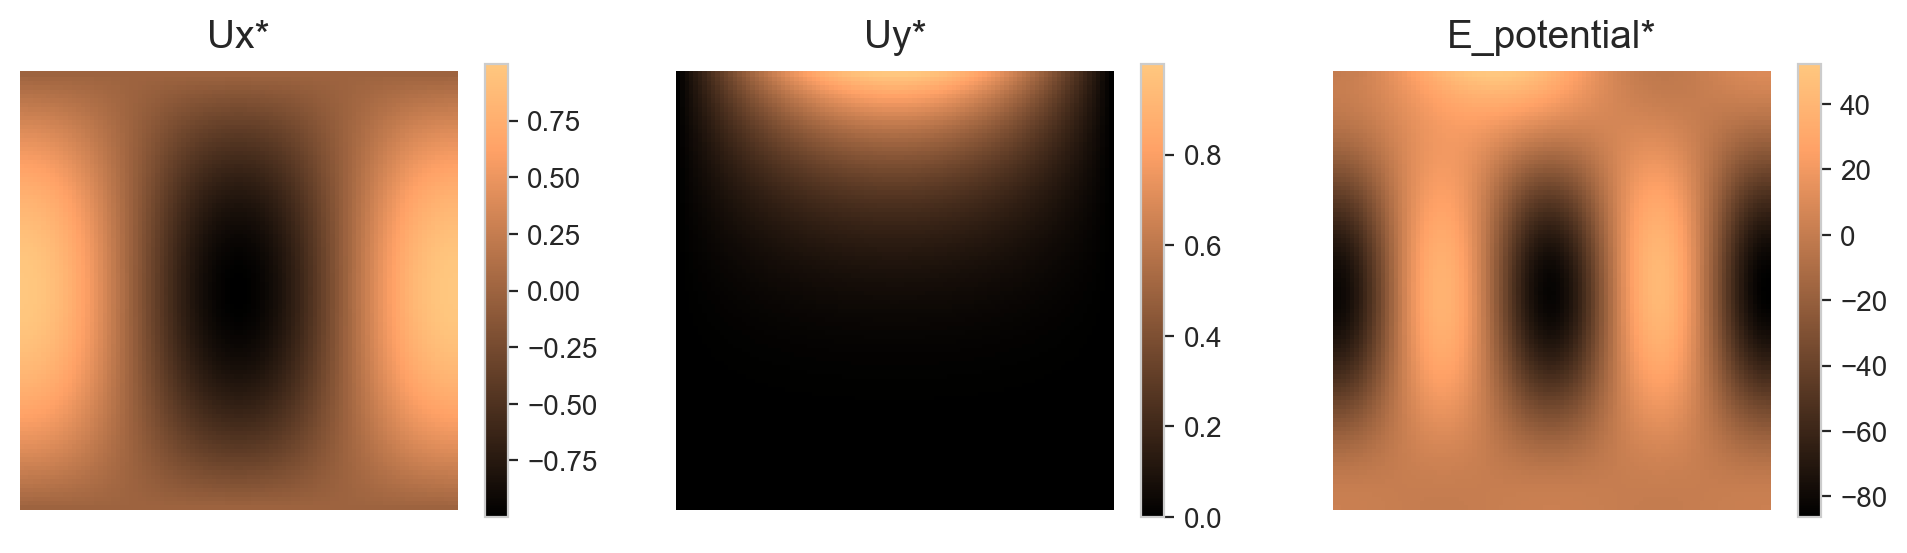

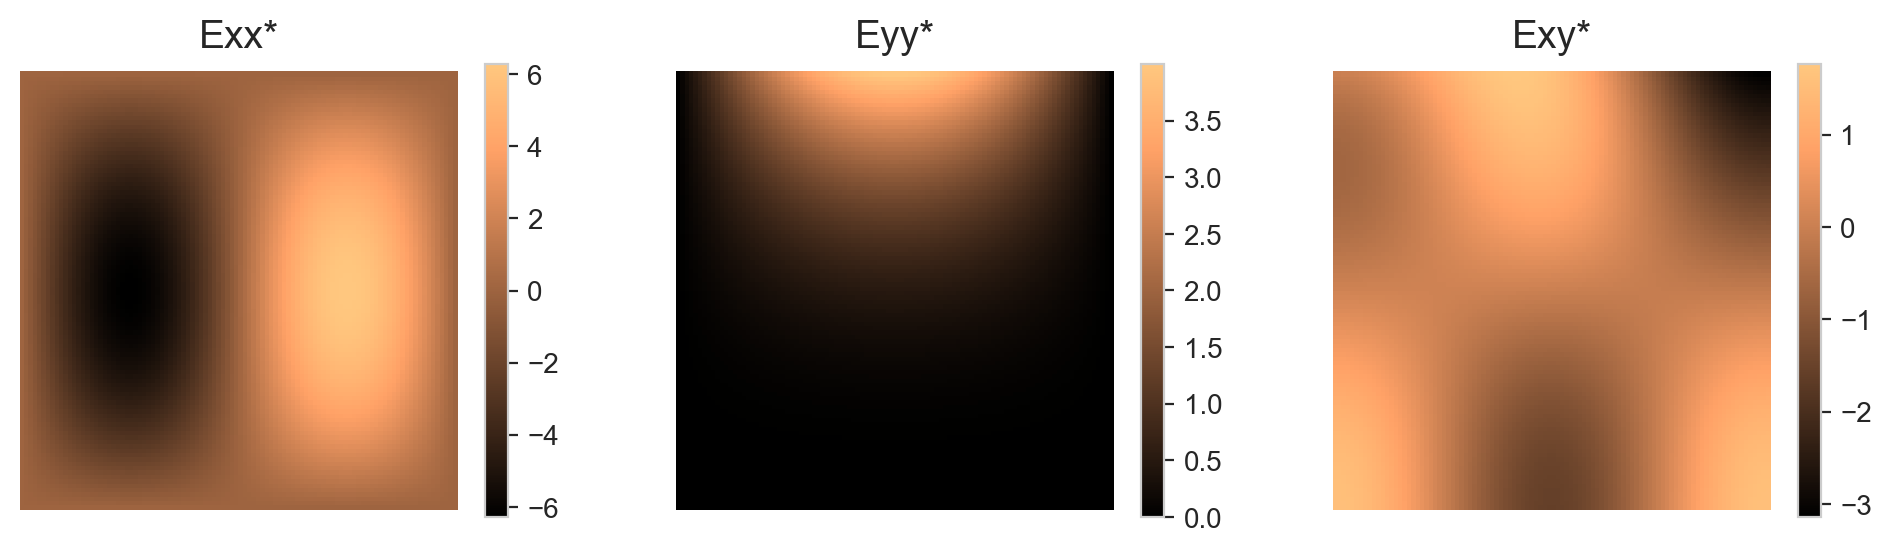

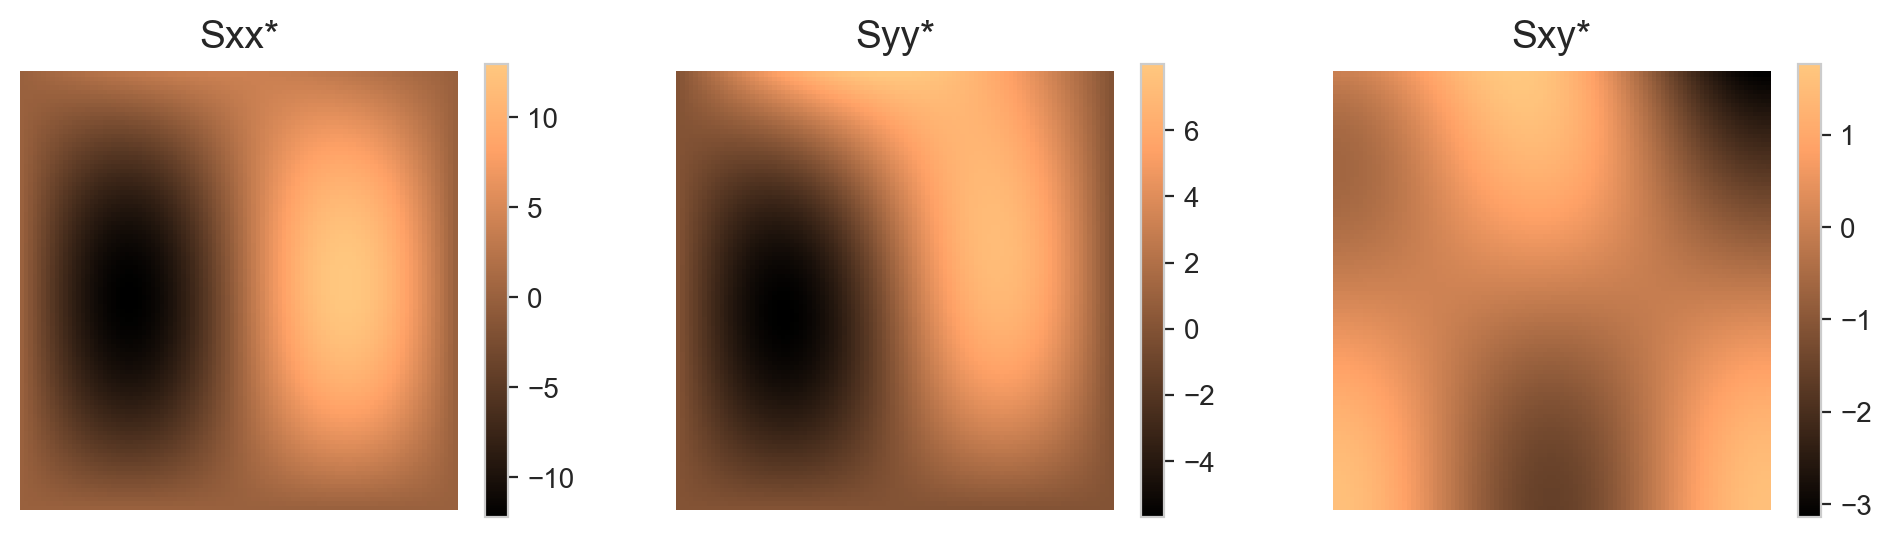

In [6]:
# plotting utilities
def pcolor_plot(AX, X, Y, C, title,colormap="copper",**kwargs):
    ## plot the pcolor plot of the given data C on the given axis AX with the given title and optional colorbar limits cmin and cmax
    if len(kwargs) == 0:
        im = AX.pcolor(X, Y, C, cmap=colormap,shading='auto')
    else:
        cmin = kwargs["cmin"]
        cmax = kwargs["cmax"]
        im = AX.pcolor(X, Y, C, cmap=colormap, vmin=cmin, vmax=cmax,shading='auto')
    AX.axis("equal")
    AX.axis("off")
    AX.set_title(title, fontsize=14)
    return im

#plotting the analytical solution
lmbd = 1.0
mu = 0.5
Q = 4.0

domain = np.array([[0.0, 1.0], [0.0, 1.0]])

X = np.linspace(domain[0][0], domain[0][1], 100)
Y = np.linspace(domain[1][0], domain[1][1], 100)
Xgrid, Ygrid = np.meshgrid(X, Y)
Xinput = np.hstack((Xgrid.reshape(-1, 1), Ygrid.reshape(-1, 1)))

fig, ax = plt.subplots(1, 3, figsize=(12, 3), dpi=200)
for i in range(2):
    im = pcolor_plot(ax[i], Xgrid, Ygrid, U_exact(Xinput)[:,i].reshape(Xgrid.shape), ["Ux*", "Uy*"][i])
    fig.colorbar(im, ax=ax[i])
im = pcolor_plot(ax[2], Xgrid, Ygrid, E_potential_exact(Xinput)[0].reshape(Xgrid.shape), "E_potential*")
fig.colorbar(im, ax=ax[2])

fig, ax = plt.subplots(1, 3, figsize=(12, 3), dpi=200)
for i in range(3):
    im = pcolor_plot(ax[i], Xgrid, Ygrid, E_exact(Xinput)[i].reshape(Xgrid.shape), ["Exx*", "Eyy*", "Exy*"][i])
    fig.colorbar(im, ax=ax[i])

fig, ax = plt.subplots(1, 3, figsize=(12, 3), dpi=200)
for i in range(3):
    im = pcolor_plot(ax[i], Xgrid, Ygrid, S_exact(Xinput)[i].reshape(Xgrid.shape), ["Sxx*", "Syy*", "Sxy*"][i])
    fig.colorbar(im, ax=ax[i])